# Predicting Marvel Movie Ratings from YouTube Comments

Kevin Nolasco

Cabrini University

MCIS565 - Natural Language Processing

05/13/2022

![MarvelRatings_Flow.jpg](MarvelRatings_Flow.jpg)

## Load Data

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter, defaultdict
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [219]:
df_comments = pd.read_json('data/movie_comments.json')
df_ratings = pd.read_json('data/movie_ratings.json')

## EDA and Data Cleaning

First we will inspect the comments dataset and clean it so we can use it later.

Since our data is taken from YouTube comments, there is a chance that we see repeated comments; the repeated comments could be considered spam and will will remove them.

In [220]:
# inspect the duplicated comments
df_comments[df_comments.duplicated(['CommentAuthor', 'OriginalComment'])].tail()

,MovieName,MovieId,CommentAuthor,OriginalComment
90388,Spider-Man: No Way Home,ZYzbalQ6Lg8,UC4eL8LDWE75VraK9UfSlonQ,Malayalam please 😟😟😟
90389,Spider-Man: No Way Home,ZYzbalQ6Lg8,UC4eL8LDWE75VraK9UfSlonQ,Malayalam please 😟😟😟
90390,Spider-Man: No Way Home,ZYzbalQ6Lg8,UC4eL8LDWE75VraK9UfSlonQ,Malayalam please 😟😟😟
90391,Spider-Man: No Way Home,ZYzbalQ6Lg8,UC4eL8LDWE75VraK9UfSlonQ,Malayalam please 😟😟😟
90392,Spider-Man: No Way Home,ZYzbalQ6Lg8,UC4eL8LDWE75VraK9UfSlonQ,Malayalam please 😟😟😟


In [221]:
# remove the duplicates
df_comments.drop_duplicates(subset = ['CommentAuthor', 'OriginalComment'], inplace = True, keep = False)
df_comments.head()

,MovieName,MovieId,CommentAuthor,OriginalComment
0,Iron Man,8ugaeA-nMTc,UCQzG9JFe87-FrpMAVZjX_Kg,honestly this is still the best marvel movie imo
1,Iron Man,8ugaeA-nMTc,UC1bmGHVTIBOerbW2P-pJsog,2:10 2:11
2,Iron Man,8ugaeA-nMTc,UC7A-gvQcpTmkBs1c0FJU92Q,This just shows the whole movie lmao😂
3,Iron Man,8ugaeA-nMTc,UC4r37ZNp-chrosonJ2VsdEg,14 years
4,Iron Man,8ugaeA-nMTc,UC0QY_nzoJvlb5z-dfwnVGsA,2:14


Now let's see how many comments are left, we will check for duplicates once more to ensure the duplicates are gone.

In [222]:
# drop duplicates if any
n_rows_comments = df_comments.shape[0]
n_rows_comments_deduped = df_comments.drop_duplicates(subset = ['CommentAuthor', 'OriginalComment']).shape[0]
print("""
Number of rows in dataset : {}
Number of rows deduped : {}
""".format(n_rows_comments, n_rows_comments_deduped))


Number of rows in dataset : 89336
Number of rows deduped : 89336



Let's see some simple statistics for our dataset.

- How many comments total?
- How many comment authors?
- How many movies?
- Which movie has the most comments?
- What is the average number of comments per movie?
- How many character are the shortest and longest comments?
- What is the average number of characters per comment?

In [223]:
# answering the questions above
n_comments = df_comments.shape[0]
n_comment_authors = df_comments['CommentAuthor'].nunique()
n_movies = df_comments['MovieName'].nunique()
movie_with_most_comments, most_comments_count = df_comments.groupby(by = 'MovieName').size()\
    .sort_values(ascending = False).reset_index(name = 'comment_count').iloc[0].values
avg_number_of_comments = int(df_comments.groupby(by = 'MovieName').size().mean())

df_comments['comment_length'] = df_comments['OriginalComment'].apply(lambda comment: len(comment))
shortest_comment_len, longest_comment_len, avg_comment_len = df_comments['comment_length'].min(), df_comments['comment_length'].max(), df_comments['comment_length'].mean() 

print("""
Dataset Stats:\n
{:,} comments\n
{:,} comment authors\n
{} unique movies\n
"{}" contains the most comments - ({:,} comments)\n
On average, the movies in the dataset contain {:,} comments\n
The shortest comment contains {} characters\n
The longest comment contains {:,} characters\n
The average number of characters per comment is {:,.0f}\n
""".format(n_comments, n_comment_authors, n_movies, \
    movie_with_most_comments, most_comments_count, \
        avg_number_of_comments, shortest_comment_len,\
            longest_comment_len, avg_comment_len))


Dataset Stats:

89,336 comments

77,533 comment authors

26 unique movies

"Black Widow" contains the most comments - (4,005 comments)

On average, the movies in the dataset contain 3,436 comments

The shortest comment contains 0 characters

The longest comment contains 34,594 characters

The average number of characters per comment is 75




## Plot for Comments By Movies

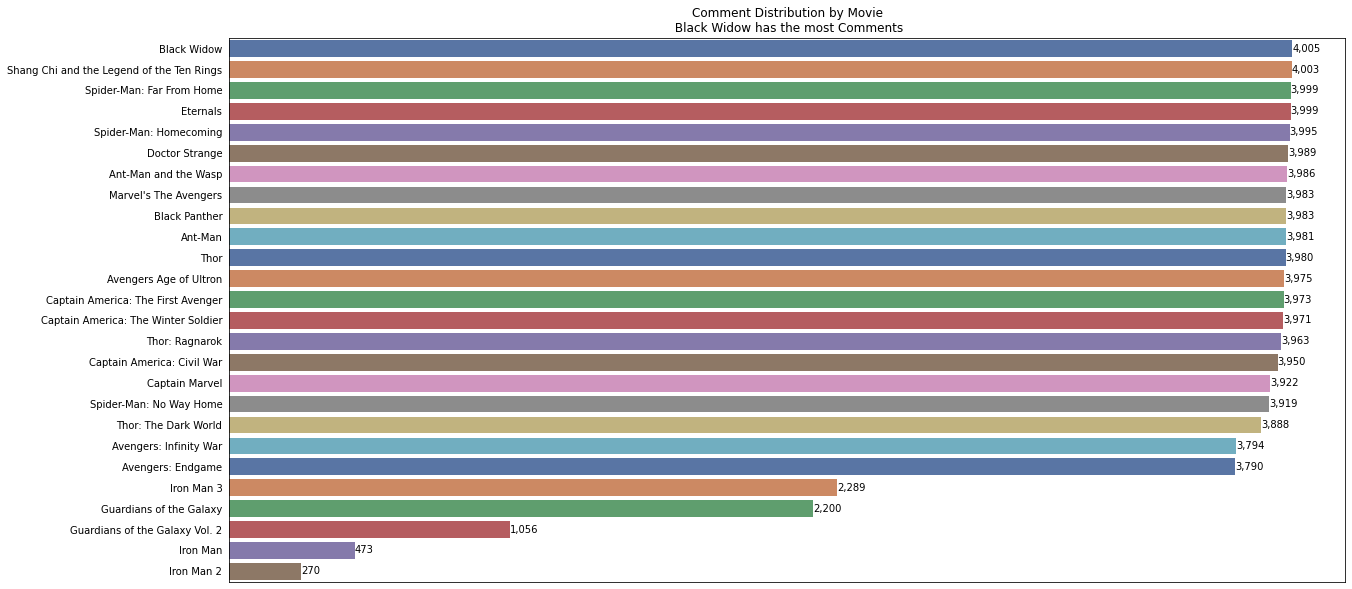

In [224]:
# function to help plot
def create_plots(rows = 1, cols = 1):
    fig, axs = plt.subplots(rows, cols)
    fig.set_size_inches(20,10)
    return fig, axs

def clean_plot(fig, axs, g, title):
    """
    remove ticks, add title, add counts above bars, remove grid lines
    """
    plt.tick_params(left = False, bottom = False , labelbottom = False)
    g.set(ylabel = None, xlabel = None, title = title)
    g.bar_label(g.containers[0], labels = ['{:,.0f}'.format(val) for val in g.containers[0].datavalues])
    axs.grid(False)

fig, axs = create_plots()
g = sns.countplot(data = df_comments, y = 'MovieName', order = df_comments['MovieName'].value_counts().index, \
    palette = 'deep')
clean_plot(fig, axs, g, 'Comment Distribution by Movie\n Black Widow has the most Comments')
plt.show()

## Plot for most Frequently Used Words

In [225]:
# let's see what the top 20 most common words are
Counter(' '.join(df_comments['OriginalComment']).lower().split()).most_common(20)

[('the', 53186),
 ('i', 27136),
 ('this', 25154),
 ('is', 21179),
 ('and', 20973),
 ('to', 20264),
 ('a', 19284),
 ('in', 17997),
 ('of', 17223),
 ('movie', 16170),
 ('it', 12648),
 ('was', 11071),
 ('that', 10242),
 ('for', 8396),
 ('you', 7802),
 ('trailer', 7250),
 ('so', 7018),
 ('like', 6841),
 ('marvel', 6493),
 ('but', 6434)]

From above, we can see the most common word is "the". That's not very helpful, so we will remove the stop words from the dataset.

In order to conserve the meaning of the sentences, we will perform lemmatization using NLTK before removing stopwords in order to capture the correct POS. Since the purpose of this project is to find the sentiment of the comments, we will keep the stopwords in new column of the dataframe but remove them in another.

In [226]:
class CommentCleaner:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.pos_map = defaultdict(lambda: 'n')
        self.pos_map.update({'VB' : 'v',
                            'VBD' : 'v',
                            'VBG' : 'v',
                            'VBN' : 'v',
                            'VBP' : 'v',
                            'VBZ' : 'v',
                            'JJ' : 'a',
                            'JJR' : 'a',
                            'JJS' : 'a',
                            'RB' : 'r',
                            'RBR' : 'r',
                            'RBS' : 'r',
                            'WRB' : 'r'
                            })
    
    def lemmatize_comments(self, comment):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word, self.pos_map[pos]) for (word, pos) in nltk.pos_tag(word_tokenize(comment))]

    def clean_comments(self, comment, remove_stopwords = False):
        # lower case all
        comment = comment.lower()
        # remove hyperlinks
        comment = re.sub(r'^https?:\/\/.*', '', comment)
        # remove punctuations
        comment = comment.translate(str.maketrans('', '', string.punctuation))
        # replace numbers with the word "number"
        comment = re.sub(r'[0-9]+', 'number', comment)
        # lemmatize words
        comment_lemmatized = self.lemmatize_comments(comment)
        if remove_stopwords:
            final = ' '.join([word for word in comment_lemmatized if word not in self.stop_words])
        else:
            final = ' '.join(comment_lemmatized)
        return final

In [227]:
# lemmatize and remove stop words
comment_cleaner = CommentCleaner()
df_comments['comment_cleaned'] = df_comments['OriginalComment'].apply(comment_cleaner.clean_comments, args = ([True]))
df_comments['comment_lemmatized_only'] = df_comments['OriginalComment'].apply(comment_cleaner.clean_comments)

In [228]:
# show that the functions worked as intended
original_example = df_comments['OriginalComment'].iloc[30]
example_lemmatized_no_sw = df_comments['comment_cleaned'].iloc[30]
example_lemmatized = df_comments['comment_lemmatized_only'].iloc[30]

print('Example of Original Sentence before Lemmatizing and removing stopwords\n', original_example, '\n')
print('Same sentence after Lemmatizing and removing stopwords\n', example_lemmatized_no_sw, '\n')
print('Same sentence after only Lemmatizing and removing stopwords\n', example_lemmatized, '\n')

Example of Original Sentence before Lemmatizing and removing stopwords
 I am watching this for the first time :)) I actually watched Iron Man back in 2008 without looking at the trailer. Old days :)) 

Same sentence after Lemmatizing and removing stopwords
 watch first time actually watch iron man back number without look trailer old day 

Same sentence after only Lemmatizing and removing stopwords
 i be watch this for the first time i actually watch iron man back in number without look at the trailer old day 



From above, we can see that the lemmatization and removing stopwords worked. Now let's see what the top 50 most common words are for the cleaned comments.

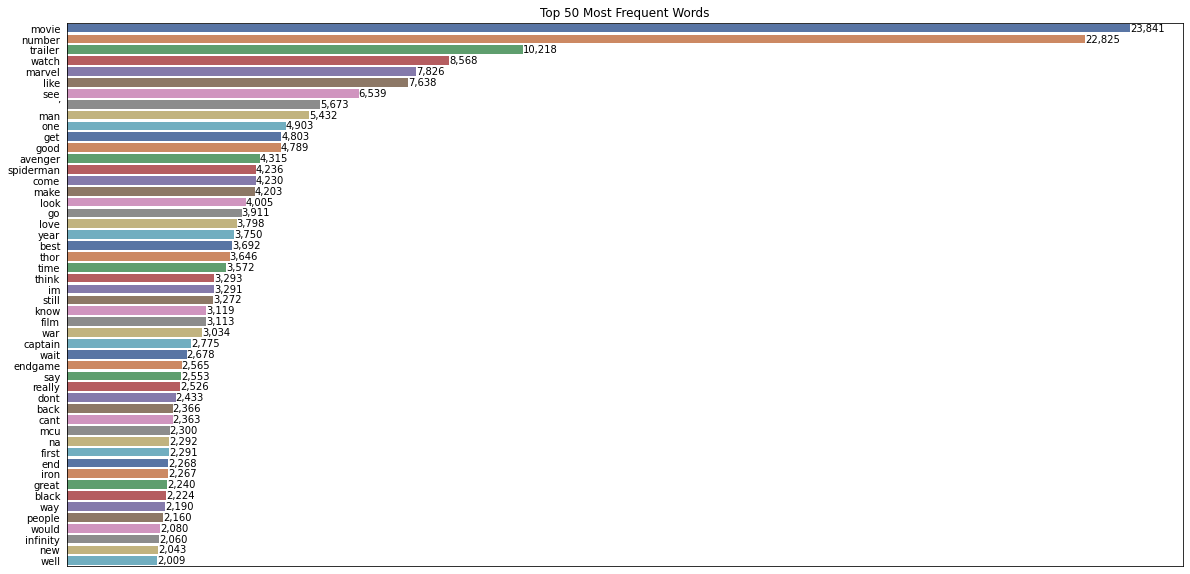

In [229]:
# compile list of words and counts for top 50 most frequent words
words_and_counts = Counter(' '.join(df_comments['comment_cleaned']).lower().split()).most_common(50)
words = [word for word, _ in words_and_counts]
counts = [count for _, count in words_and_counts]

fig, axs = create_plots()

g = sns.barplot(x = counts, y = words, palette = 'deep')

clean_plot(fig, axs, g, title = 'Top 50 Most Frequent Words')
plt.show()

We see some familiar words for marvel: "avenger", "spiderman", "thor", "captain", "endgame", "infinity". Let's use a word cloud to represent the same words.

In [230]:
words_and_counts = Counter(' '.join(df_comments['comment_cleaned']).lower().split()).most_common(1000)
words = [word for word, _ in words_and_counts]
counts = [count for _, count in words_and_counts]

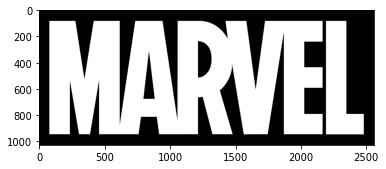

In [231]:
# load marvel logo and convert to black and white
marvel_mask = np.array(Image.open('Marvel_Logo.svg.png'))
row_means = marvel_mask.mean(axis = 1)
threshold = row_means.max()
vectorized_threshold = np.vectorize(lambda val: 255 if val < threshold else 0)
marvel_mask = vectorized_threshold(marvel_mask)
plt.imshow(marvel_mask, cmap = mpl.cm.binary)
plt.show()

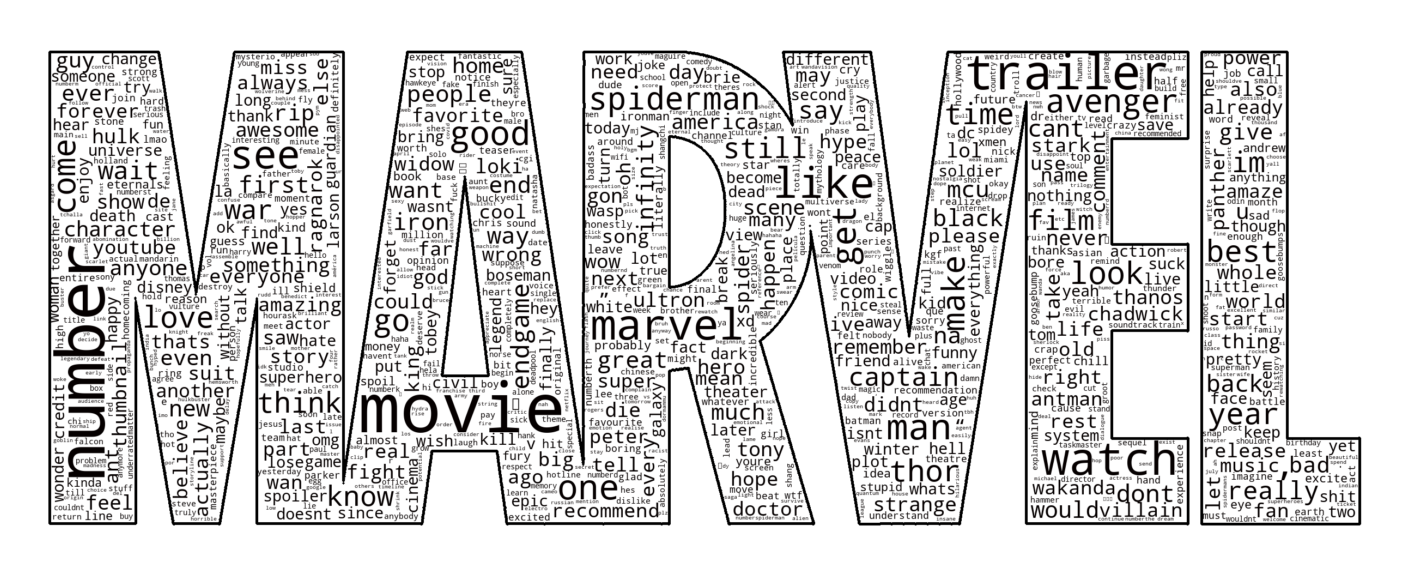

In [232]:
# change font color
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

word_cloud = WordCloud(background_color = 'white', width = 5000, \
    height = 3000, max_words = 1000, mask = marvel_mask, \
        contour_width = 5, contour_color = 'black').generate_from_frequencies({word:count for word, count in zip(words, counts)})

word_cloud.recolor(color_func = black_color_func)
plt.figure(figsize = [25,15])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()